<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [84]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [85]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [86]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [87]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

#X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

# Dequantization
uniform = torch.distributions.uniform.Uniform(torch.tensor([-0.5]), torch.tensor([0.5]))

X_train = torch.tensor(X_train) + uniform.sample(X_train.shape).squeeze()
X_train = X_train / X_train.max()
X_train = rescale(X_train, 0., 1.).numpy()

train_data = Data(X_train)


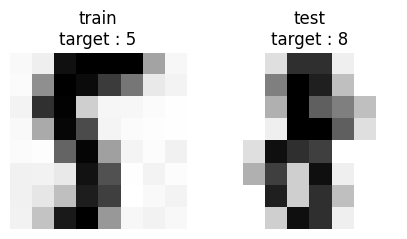

In [88]:
random_number = torch.randint(0, 9, [1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='binary')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='binary')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [89]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=10)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [90]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  91.59025997585721
Epoch :  100   -----------> Loss :  5.926703855726454
Epoch :  200   -----------> Loss :  -64.51107330322266
Epoch :  300   -----------> Loss :  -93.4351094563802
Epoch :  400   -----------> Loss :  -104.91532067192925
Epoch :  500   -----------> Loss :  -113.17220187717014
Epoch :  600   -----------> Loss :  -120.48711988661024
Epoch :  700   -----------> Loss :  -124.57936655680338
Epoch :  800   -----------> Loss :  -129.1493659125434
Epoch :  900   -----------> Loss :  -131.36209343804254
Epoch :  1000   -----------> Loss :  -138.34372016059027


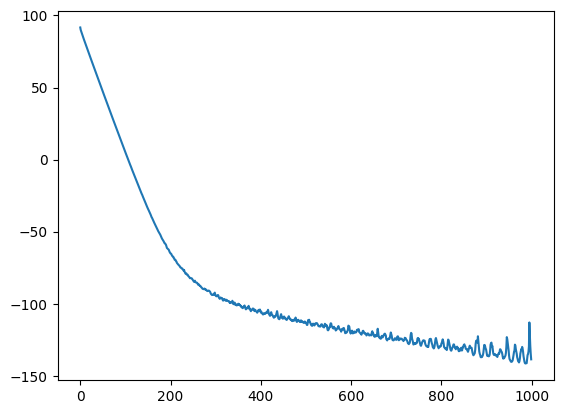

In [91]:
plt.plot(COST)

In [92]:
test = prior.sample((50,))
test

tensor([[-1.5047e+00, -1.0805e+00, -6.5122e-01,  ..., -2.4669e-01,
         -1.7508e+00, -5.1846e-01],
        [-4.6064e-01,  2.8887e+00,  5.1751e-01,  ...,  6.0441e-01,
         -2.1708e+00, -2.5027e-02],
        [-4.3201e-01, -7.6816e-01,  1.0833e+00,  ...,  6.1945e-01,
          2.5996e+00,  6.0881e-01],
        ...,
        [ 1.3219e+00,  1.0636e+00,  1.7893e-01,  ...,  1.4166e+00,
         -9.3128e-01, -6.3554e-01],
        [ 4.0122e-01, -2.1780e-03,  1.0586e-01,  ..., -7.4343e-02,
          2.3468e-01,  5.4283e-01],
        [-1.0353e+00, -1.1412e+00,  4.5130e-01,  ..., -1.2145e+00,
         -9.4836e-01,  1.7364e-01]])

In [93]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 0.0213, -0.0263,  0.4588,  ...,  0.8813,  0.9395,  0.4203],
        [ 0.0264,  0.1119,  0.8072,  ...,  0.0368,  0.0576,  0.0593],
        [ 0.0392,  0.0172,  0.3851,  ...,  0.1333,  0.0072,  0.0242],
        ...,
        [ 0.0236,  0.0040,  0.1476,  ..., -0.0120,  0.0229,  0.0253],
        [ 0.0216,  0.0085,  0.0716,  ...,  0.8122,  0.4596,  0.0316],
        [ 0.0165,  0.0175,  0.7242,  ..., -0.0043,  0.0191,  0.0496]],
       grad_fn=<MulBackward0>)

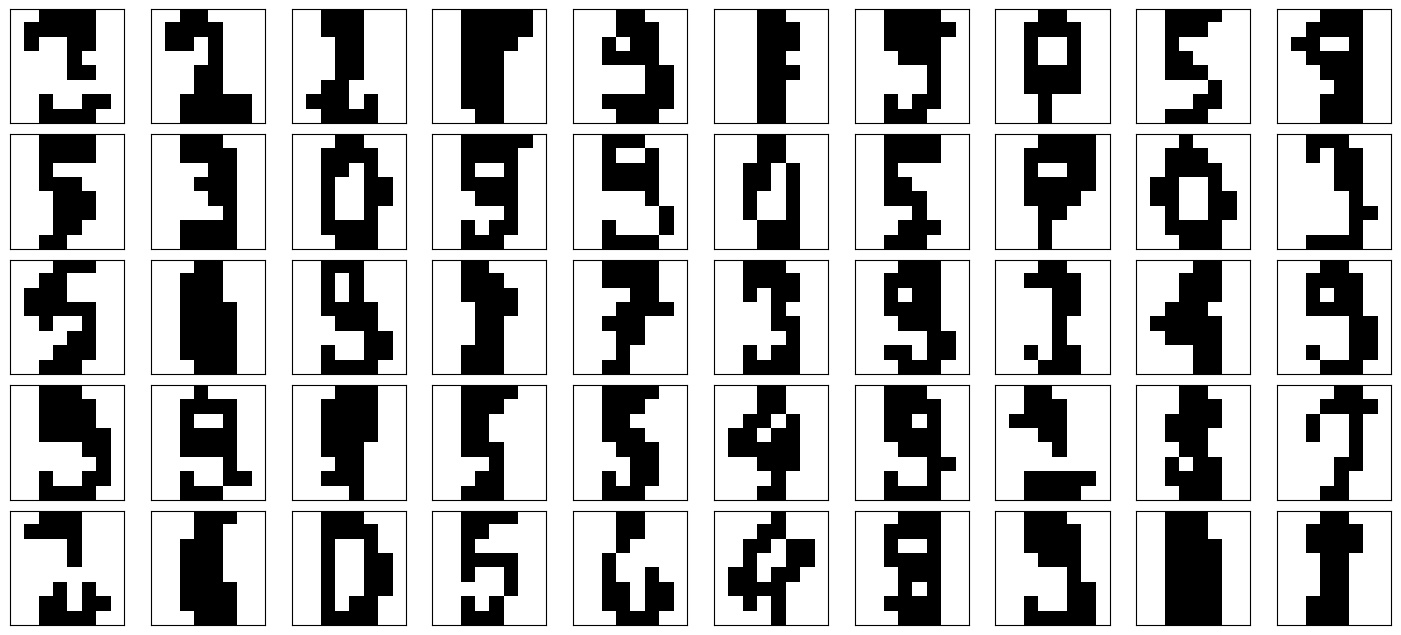

In [106]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>=0.4] = 1
sonuc[sonuc[:]<0.4] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):
    axs[0, i].imshow((sonuc[i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

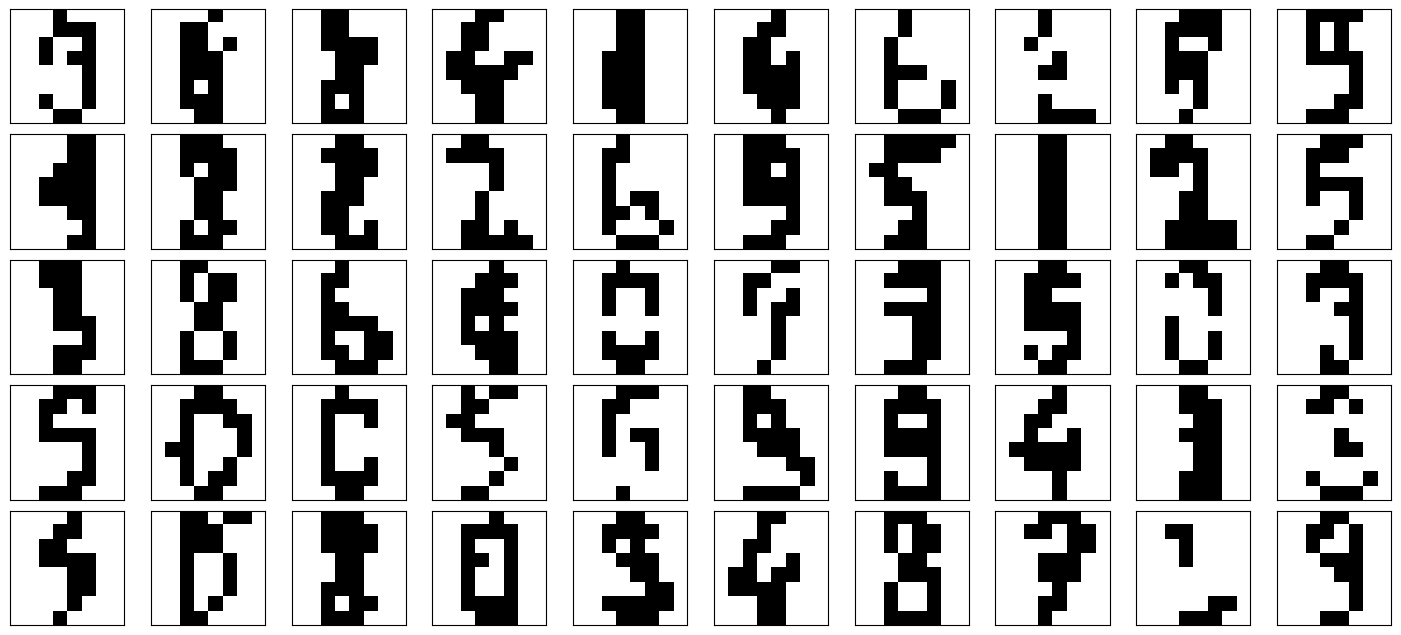

In [107]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):
    axs[0, i].imshow((sonuc[i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

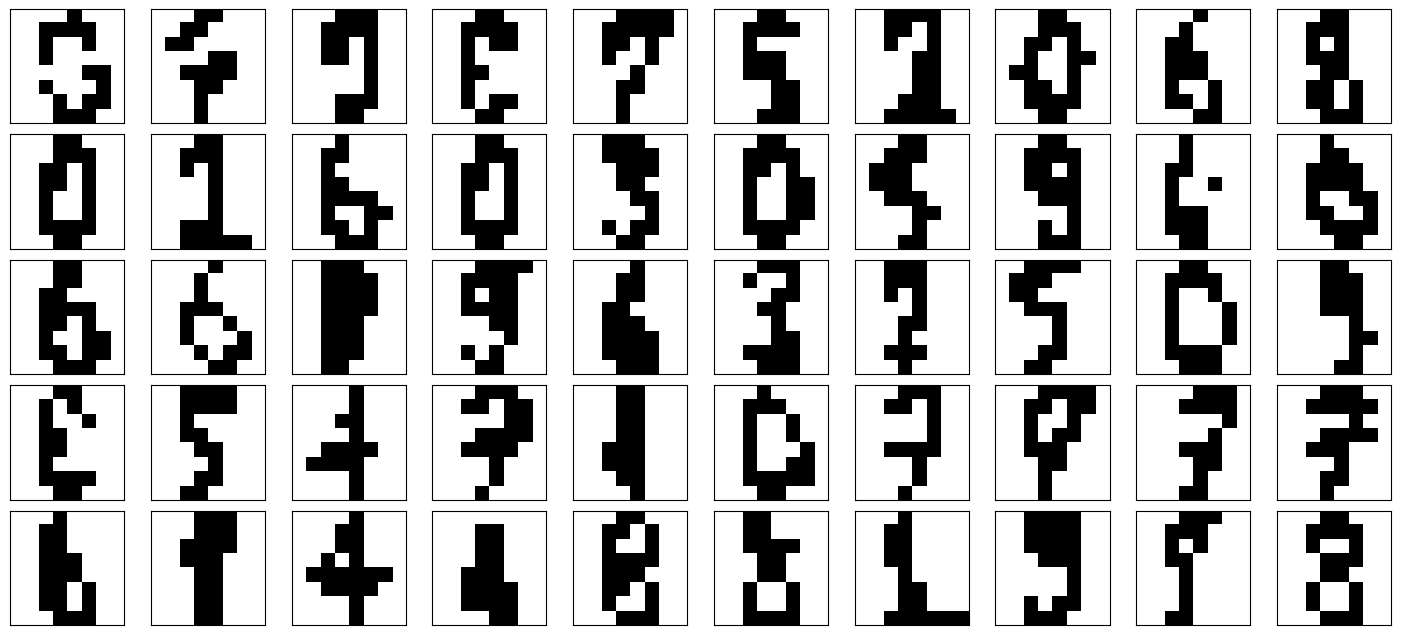

In [105]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):
    axs[0, i].imshow((sonuc[i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [97]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [98]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(360, 2)


In [99]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(360, 2)


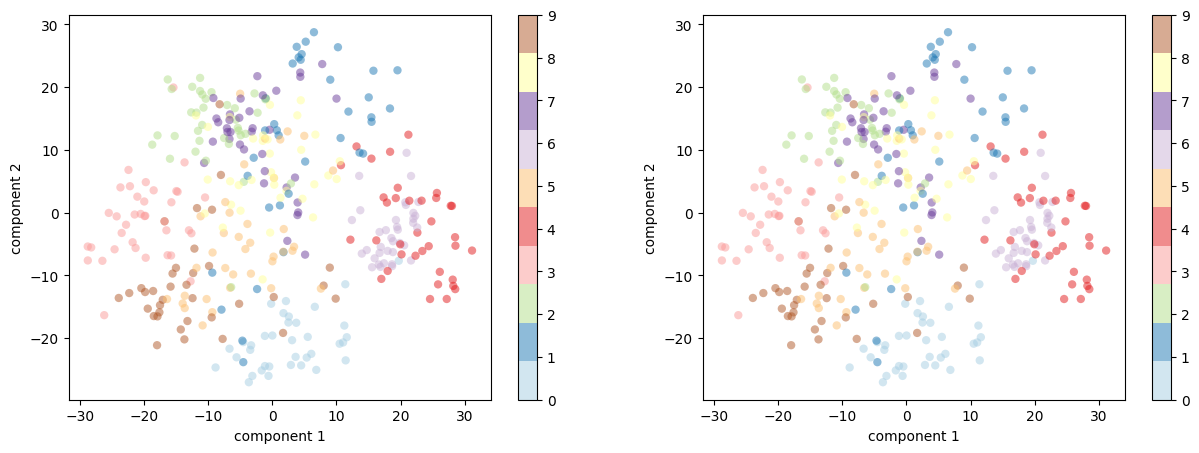

In [100]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()